# Regresión Ridge

Una alternativa para resolver el problema de colinealidad, condicionamiento incluso selección de variables es la regresión Ridge. Este método es conocido como regresión Ridge en el campo de la estadística, pero también es conocido como *regularizacion de Tychonoff* pues la heurística es proponer una penalización en un problema de estimación. 

## Introducción 
Para resolver el problema de multicolinealidad que tiende a producir valores grandes en norma L2 del vector $\hat{\beta}$ impones una penalización a dicha norma en el problema de mínimos cuadrados, luego 
$$
\hat{\beta}_{\text{Ridge}}=\text{argmin}_{\beta} \lVert y-X\beta \rVert_2^2+\lambda \lVert \beta \rVert_2^2.
$$

Esta es la forma dual del problema prima de optimizacion con restricciones 
$$
\hat{\beta}_{\text{Ridge}}=\text{argmin}_{\beta} \lVert y-X\beta \rVert^2,
$$
sujeto a 
$$
\lVert \beta \rVert_2^2 \leq t,
$$
para algún $t$.


**Nota:** Hay una relación biunivoca entre $t$ y $\lambda$ debido a las condiciones KKT y la dualidad. 

Se puede probar fácilmente que 
$$
\hat{\beta}_{\text{Ridge}}=(X^TX+\lambda I)^{-1}X^Ty
$$

A continuacion desarrollamos intuición geométrica sobre lo que significa resolver el problema de optimización con restricciones.

In [ ]:
import numpy as np 
import sklearn as skl
import matplotlib.pyplot as plt

In [ ]:
# Modelo Cuadrático: y = x'Ax+ x'b = x'(Ax+b)

# matriz de rotacion (eigen vectores)
alpha=np.pi/12
R = np.matrix([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]]) 
# eigenvalores
D = np.matrix([[1,0],[0,0.2]]) 
# Hessianob
A = 3*np.dot(R,np.dot(D,R.T))
# translacion
b = np.matrix([[-1],[-2]])

#Region a "plotear"
delta = 0.05
x1 = np.arange(-0.5, 2.0, delta)
x2 = np.arange(-0.5, 2.0, delta)
X1, X2 = np.meshgrid(x1, x2)

# calculo del modelo cuadratico
rows, cols = X1.shape
Y = np.zeros((rows,cols))
for i in range(rows):
    for j in range(cols):
        x = np.matrix([X1[i,j],X2[i,j]]).T
        Y[i,j]=  np.dot(x.T, np.dot(A,x) + b)

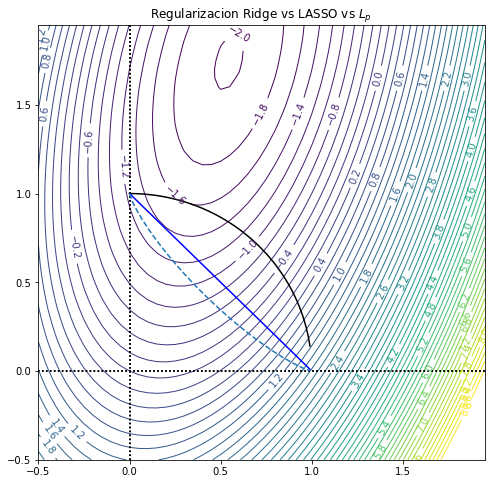

In [ ]:
plt.figure(figsize=(8,8))

# El potencial Quadrático
levels = np.arange(-2.0, 9, 0.2)
CS = plt.contour(X1, X2, Y, levels,
                 linewidths=1,
                 extent=(-3, 3, -2, 2))

#CS = plt.contour(X1, X2, Y)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Regularizacion Ridge vs LASSO vs $L_p$ ')
#-------------------------------------
#Penalizacion L_2
x = np.arange(0,1,0.01)
y = np.sqrt(1-np.power(x,2))
plt.axvline(0.0,ls='dotted', color='k')
plt.axhline(0.0,ls='dotted', color='k')
plt.plot(x,y,'k')
#-------------------------------------
#Penalizacion L_1
x = np.arange(0,1,0.01)
y = 1-x
plt.axvline(0.0,ls='dotted', color='k')
plt.axhline(0.0,ls='dotted', color='k')
plt.plot(x,y,'b')
#-------------------------------------
#Penalizacion L_p, con p=0.4
x = np.arange(0,1,0.01)
p = .8
y = np.power(1-np.power(x,p),1/p)
plt.axvline(0.0,ls='dotted', color='k')
plt.axhline(0.0,ls='dotted', color='k')
plt.plot(x,y,'--')
#-------------------------------------

plt.show()

## Traza de Ridge

Queremos comparar cual es la diferencia sustancial entre las estimaciones por mínimos cuadrados y la estimación Ridge para ello usaremos la SVD, una factorización de matrices fundamental en el análisis de métodos estadísticos y computacionales. 

Sea la SVD de X
$$
X=UDV^T.
$$

Por un lado podemos ver que el estimador de minimos cuadrados en términos de la SVD es
$$
X\hat{\beta}_{OLS}=UU^Ty,
$$
mientras que 
$$
X\hat{\beta}_{\text{Ridge}}=\sum_{j=1}^p\left(\frac{d_j^2}{d_j^2+\lambda}\right)yu_ju_j^T.
$$

Observamos que se penalizan aquellas variables con los $d_j^2$ más pequeños, es decir, aquellas varianza explicada es la más pequeña, esta es una forma de realizar la selección de variables. 

Definimos la traza de Ridge precisamente por la suma de estas ponderaciones
$$
\text{df}(\lambda)=\text{Tr}(X(X^TX+\lambda I)^{-1}X^T)=\sum_{j=1}^{p}\frac{d_j^2}{d_j^2+\lambda}.
$$

Notamos que $\text{df}(\lambda)=p$ cuando $\lambda=0$ mientras que $\text{df}(\lambda)\to 0$ cuando $\lambda\to \infty$.

**Nota** Siempre hay un grado de libertad para el intercepta pero este se remueve *a priori* cuando centramos la matriz de diseño.

Se mostrará un ejemplo en el cual se puede utilizar la traza de Ridge para elegir un modelo asi como se realiza un analisis de multicolinealidad 

## Ejemplo

Ejemplificaremos el uso de la regression Ridge para resolver el problema de multicolinealidad y mal condicionamiento de la matriz de diseño. 

Hay dos puntos importantes que se deben considerar en el análisis. 
1. La elección óptima del parámetro de regularización ya sea $\lambda$ o $t$.
2. Selección del modelo a partir de la varianza explicada. 

### Analisis de Multicolinealidad

A continuación, hacemos un breve análisis de la multicolinealidad inherente a los datos, haciendo un mapa de calor de la correlación existente entre las variables así como una visualzación gráfica a partir del scatter plot. 

<AxesSubplot:>

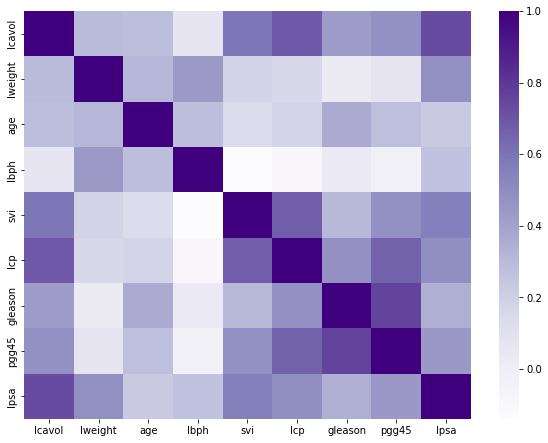

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

data = pd.read_csv("prostate_dataset.txt", sep='\t')
data = data.drop(['col'], axis=1)

data
# The data were collected on n=97 men before radical prostatectomy,
# which a major surgical operation that removes the entire prostate
# gland along with some surrounding tissue.

# lcavol  = log cancer volumne, measure in milliliters (cc). The area
#           of cancer was measure from digitized images and multiplied
#           by a thickness to produce a volume.
# lweight = log prostate weight
# age     = age
# lbph    = log of the amount of benign prostatic hyperplasia, a
#           noncancerous enlargement of the prostate gland, as an area in
#           a digitized image and reported in cm2.
# svi     = seminal vesicle invasion, a 0/1 indicator of whether prostate
#           cancer cells hae invaded the vesicle.
# lcp     = log capsular penetration, which represents the level of
#           extension of cancer into the capsule (the fibrous tissue
#           which acts as an outer lining of the prostate gland).
#           Measure as the linear extent of penetration, in cm.
# gleason = Gleason score, a measure of the degree of aggressiveness of
#           the tumor. The Gleason grading system assigns a grade
#           to each of the two largest areas of cancer in the tissue
#           samples with 1 being the least aggressive and 5 the most
#           aggressive; the two grades are then added together to produce
#           the Gleason score.
# pgg45   = percent of Gleason score 4 or 5.
# lpsa    = log prostate specific antigen

# See Hastie et al (2008) The Elements of Stat. Learning (pp. 49)
# and Wakefiled (2013) (pp. 5)

# PSA is a concentration and is measure in ng/ml.
# In Stamey et al (1989), PSA was proposed as a preoperative marker
# to predict  the clinical stage of cancer.
# PSA is a protein produced by the cells of the prostate gland.
# PSA is present in small quantities in the serum of men with healthy
# prostates, but is often elevated in the presence of prostate cancer
# and in other prostate disorders. A blood test to measure PSA is
# considered the most effective test currently available for the early
# detection of prostate cancer, but this effectiveness has also
# been questioned. Rising levels of PSA over time are associated
# with both localized and metastatic prostate cancer.

#################################################
##                                             ##
## Creating the training and testing data sets ##
##                                             ##
#################################################

train_data = data[data['train'] == 'T']
test_data = data[data['train'] == 'F']

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

data = data.drop(['train'], axis=1)
train_data = train_data.drop(['train'], axis=1)
test_data = test_data.drop(['train'], axis=1)

X_train = train_data.drop('lpsa', axis=1)
y_train = train_data['lpsa']

X_test = test_data.drop('lpsa', axis=1)
y_test = test_data['lpsa']

###############################
##                           ##
## Exploring multicolinearty ##
##                           ##
###############################

corr_matrix = train_data.corr()
plt.figure(figsize=(10,7.5))
sns.heatmap(corr_matrix, cmap='Purples')

El scatter plot nos servirá ya que como vimos en la descripción de la base de datos hay algunas variables categóricas en la que la relación lineal es un poco diferente de interpretar. 

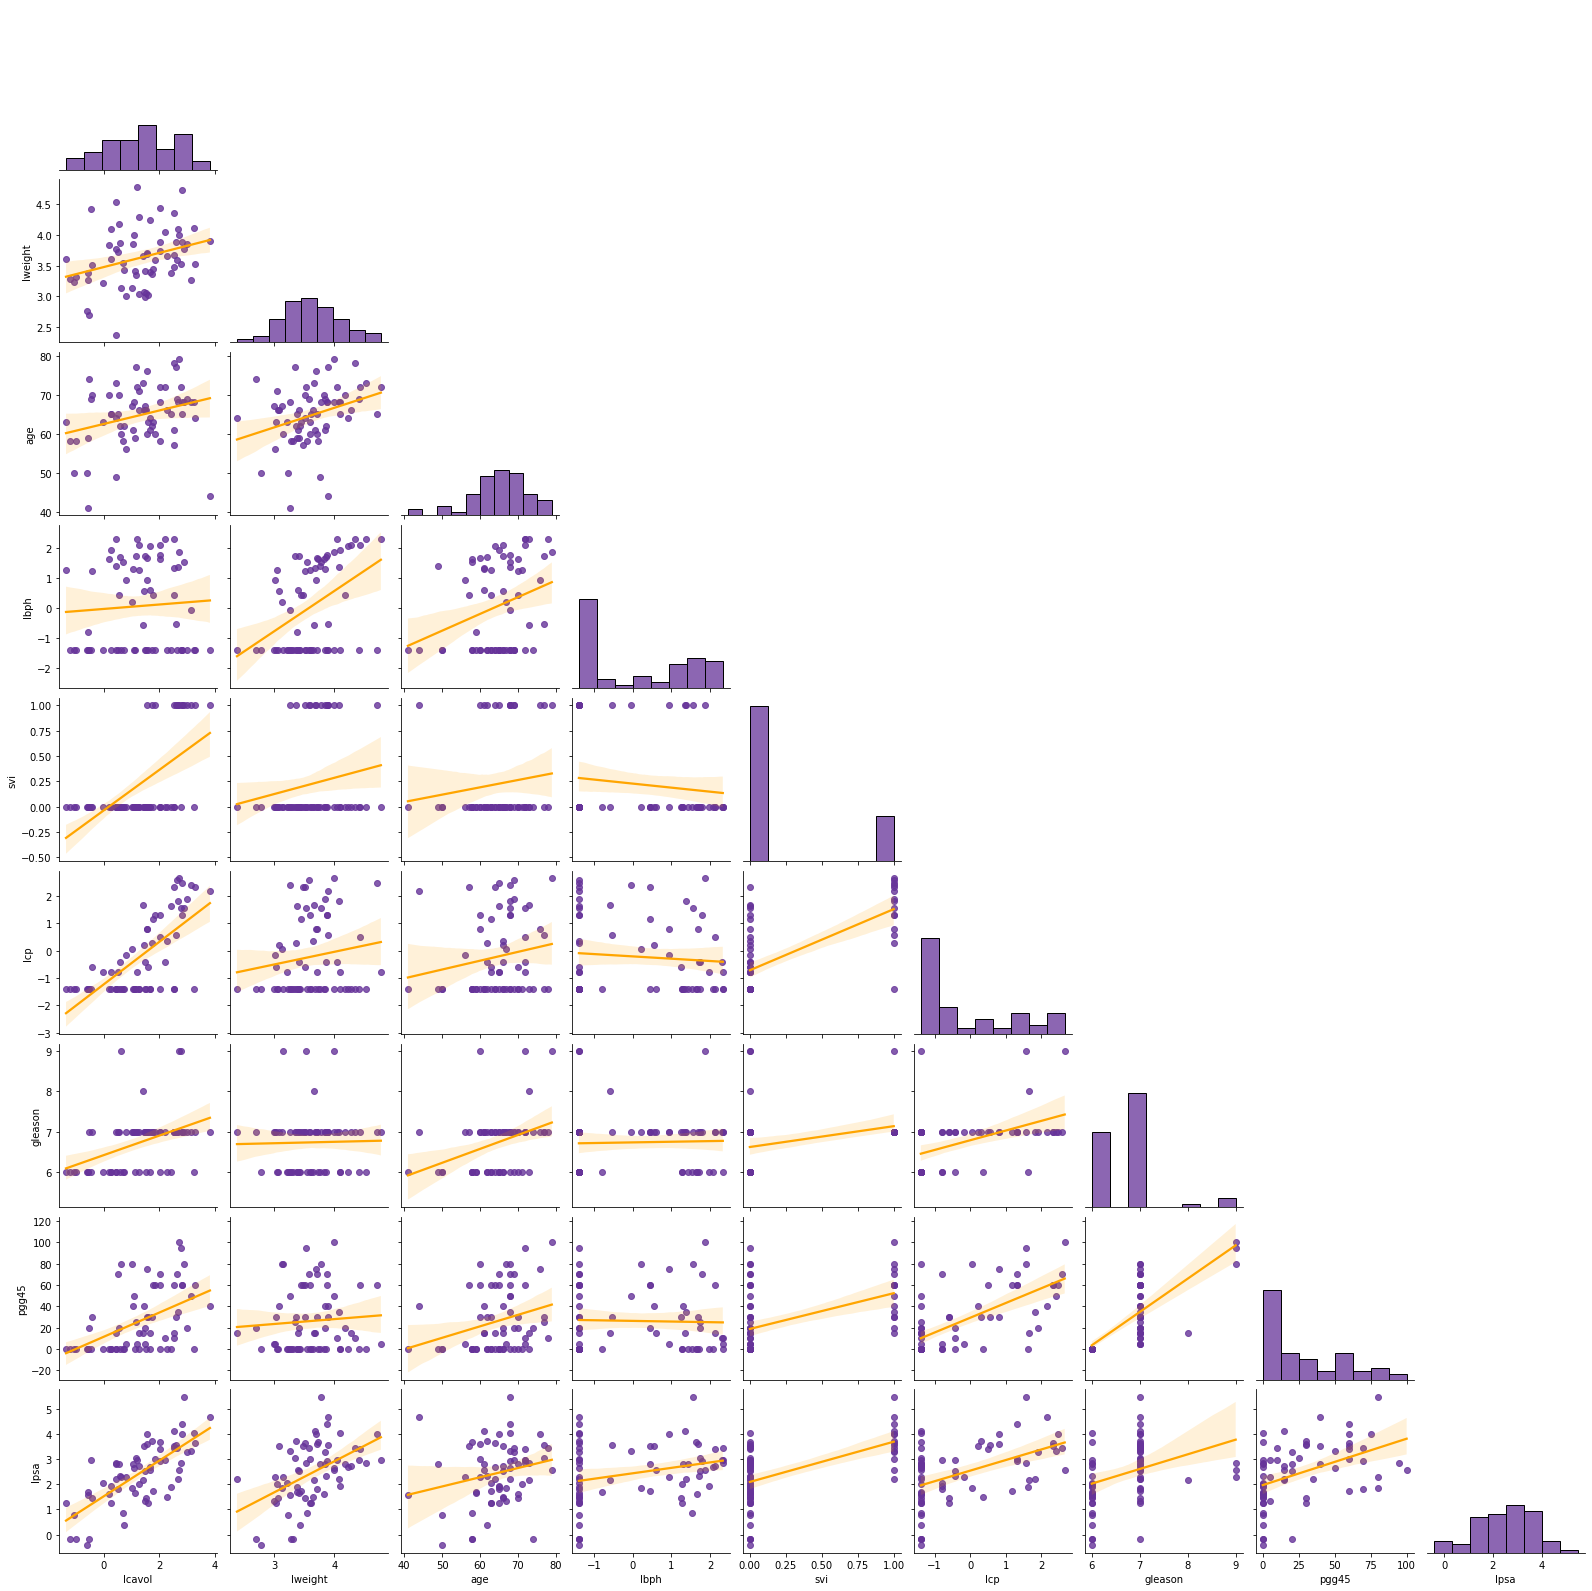

In [ ]:
sns.pairplot(train_data, kind="reg", corner = True,
    plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws': {'color': 'rebeccapurple'}},
    diag_kws={'color': 'rebeccapurple'})

A continuación, calculamos los factores de inflación de la varianza así como el número de condición de la matriz de diseño

In [ ]:
train_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('lpsa ~ lcavol+lweight+age+lbph+svi+lcp+gleason+pgg45', data=train_data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif.iloc[1:,]

,VIF,variable
1,2.318496,lcavol
2,1.472295,lweight
3,1.356604,age
4,1.383429,lbph
5,2.045313,svi
6,3.117451,lcp
7,2.644480,gleason
8,3.313288,pgg45


Vemos que hay multicolinealidad moderada pues para todas la variables. Finalmente, explorando el número de condicion.

In [ ]:
print(f'El numero de condicion de la matriz de diseño es: {np.linalg.cond(X_train.to_numpy())}')

El numero de condicion de la matriz de diseño es: 252.28059561430345


Notamos que este numero de condicion que en efecto nos dice que la matriz está mal condicionada. Valores mayores a 30 se considera un mal condicionamiento. 

### Traza de Ridge

En lo subsecuente veremos como varía el estimador Ridge a medida que variamos el parámetro de sesgo, observaremos el comportamiento suave de la regularización, muy distinta a lazo en la que se obtienen soluciones más sparse. 

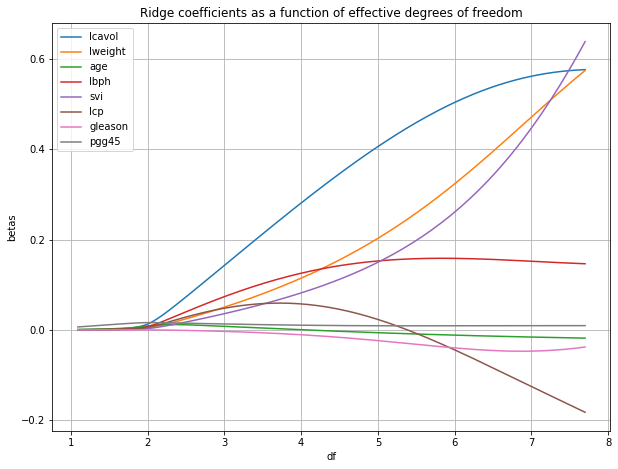

In [ ]:
# Let's see the eigenvalues of the matrix XTX
u, d, vh = np.linalg.svd(X_train, full_matrices=True)
np.round(d**2,2)

n_lambdas = 200
lambdas = np.logspace(0, 5, n_lambdas)
df_l = []
coefs = []

for l in lambdas:
    df_l.append(sum(d**2/(d**2+l)))
    ridge = Ridge(alpha=l, fit_intercept=True).fit(X_train, y_train)
    coefs.append(ridge.coef_)

fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(df_l, coefs)
ax.set_xlabel('df')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of effective degrees of freedom')
ax.grid(True)
plt.legend(X_train.columns)

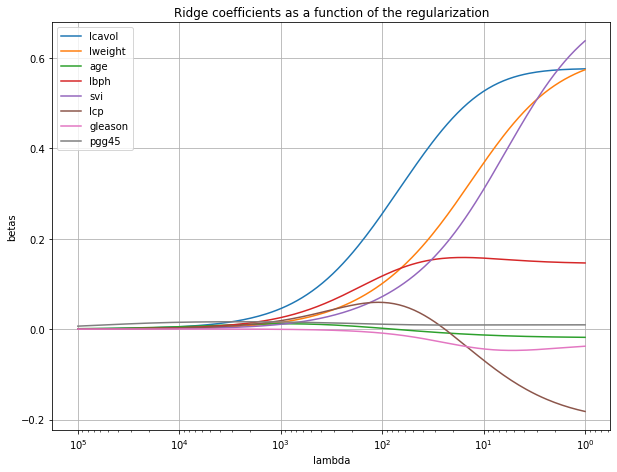

In [ ]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # decreasing time
ax.set_xlabel('lambda')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of the regularization')
ax.grid(True)
plt.legend(X_train.columns)

### Validación cruzada
Notamos con anterioridad la importancia de estimar el parámetro de sesgo óptimo para hacer un balance entre el error (MSE) y la selección del modelo. El procedimiento para dicha estimación será hacer *KFold Cross Validation* varias veces, de esta forma para cada $\lambda$ es un conjunto de valores estimamos el error promedio para cada $\lambda$. De forma equivalente, graficamos la traza de Ridge contra el MSE, sabemos que para valores grandes de $\lambda$ la traza de Ridge es 0 mientras que a medida que nos acercamos a 0 la traza coincide con el número de regresores en el modelo saturado.

Text(0.5, 1.0, 'MSE with respect to number of variables given by degrees of freedom')

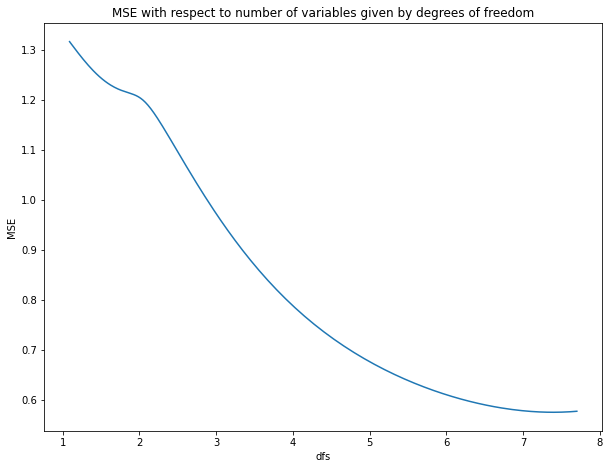

In [ ]:
n_repeats = 1
n_splits = 67
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

MSE_per_lambda_and_K_fold = np.zeros((n_repeats*n_splits, n_lambdas))

for i, index in enumerate(kf.split(X_train)):
    train_index, valid_index = index
    X_Kfold, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_Kfold, y_valid = y_train[train_index], y_train[valid_index]

    for j, l in enumerate(lambdas):
        ridge = Ridge(alpha=l).fit(X_Kfold, y_Kfold)
        hat_y_valid = ridge.predict(X_valid)
        MSE_per_lambda_and_K_fold[i,j] = mean_squared_error(y_valid, hat_y_valid)

mean_MSE = MSE_per_lambda_and_K_fold.mean(axis=0)

plt.figure(figsize=(10,7.5))
plt.plot(df_l, mean_MSE)
plt.xlabel('dfs')
plt.ylabel('MSE')
plt.title('MSE with respect to number of variables given by degrees of freedom')

In [ ]:
hat_lambda = lambdas[np.argmin(mean_MSE)]
hat_lambda
sum(d**2/(d**2+hat_lambda))
mean_MSE.min()

model_ridge = Ridge(alpha=hat_lambda).fit(X_train,y_train)
print(model_ridge.coef_)
print(model_ridge.intercept_)

[ 0.57231279  0.53111372 -0.01714663  0.14865287  0.54920041 -0.15778849
 -0.04340675  0.00954089]
0.7591075337298208


In [ ]:
clf = RidgeCV(alphas=lambdas).fit(X_train, y_train)
print(clf.alpha_)
print(clf.best_score_)
print(clf.coef_)
print(clf.intercept_)

print(mean_squared_error(y_test, clf.predict(X_test)))

2.2478058335487257
-0.5757140589657065
[ 0.57231279  0.53111372 -0.01714663  0.14865287  0.54920041 -0.15778849
 -0.04340675  0.00954089]
0.7591075337330186
0.5224999981088331


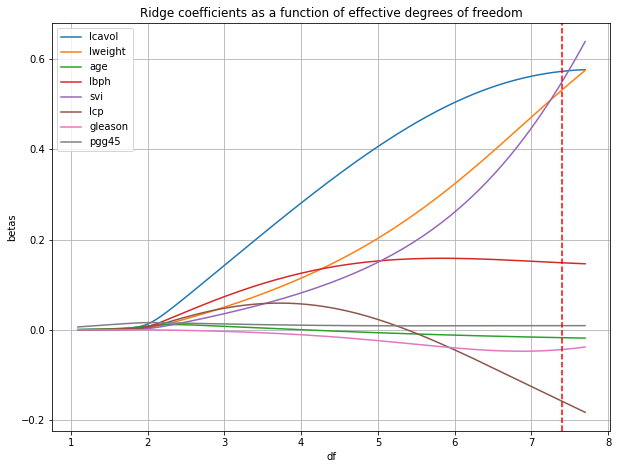

In [ ]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(df_l, coefs)
ax.set_xlabel('df')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of effective degrees of freedom')
ax.grid(True)
plt.axvline(sum(d**2/(d**2+hat_lambda)), c='r', ls='--')
plt.legend(X_train.columns)

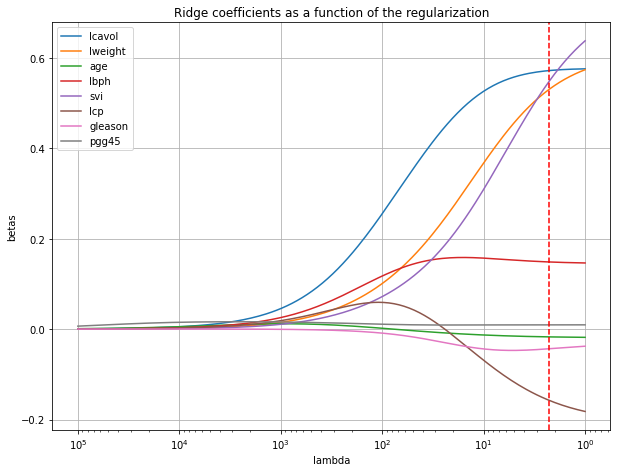

In [ ]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # decreasing time
ax.set_xlabel('lambda')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of the regularization')
ax.grid(True)
plt.axvline(clf.alpha_, c='r', ls='--')
plt.legend(X_train.columns)